 predict the cost of medical insurance for individuals based on a number of different parameters such as, age, sex, bmi, children, smoking_status and residential_region.

In [1]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
     

# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
     

# Check out the insurance dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
# Turn all categories into numbers
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head() # view the converted columns

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [3]:
# Create X & y values
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [4]:
# Create training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # set random state for reproducible splits

In [5]:
#normalizing the data

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)



In [22]:
y_train_normal=y_train/max(y_train)
y_train_normal


560     0.146883
1285    0.136352
1142    0.433244
969     0.137345
486     0.199309
          ...   
1095    0.072871
1130    0.137113
1294    0.190615
860     0.736721
1126    0.163192
Name: charges, Length: 1070, dtype: float64

In [7]:
# Non-normalized and non-one-hot encoded data example
X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [44]:
# Set random seed
tf.random.set_seed(42)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(128,activation="relu",kernel_initializer="normal"),
  tf.keras.layers.Dense(256,activation="relu",kernel_initializer="normal"),
  tf.keras.layers.Dense(256,activation="relu",kernel_initializer="normal"),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history=insurance_model.fit(X_train_normal, y_train, epochs=200, verbose=1,validation_data=(X_test_normal,y_test),
                    callbacks=tf.keras.callbacks.ModelCheckpoint("insurance_model/insurance_model.h5",save_best_only=True)) 

Epoch 1/200
34/34 [==============================] - 2s 18ms/step - loss: 13334.5430 - mae: 13334.5430 - val_loss: 12905.0625 - val_mae: 12905.0625
Epoch 2/200
34/34 [==============================] - 0s 8ms/step - loss: 12864.2588 - mae: 12864.2588 - val_loss: 11448.2178 - val_mae: 11448.2178
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 9702.2695 - mae: 9702.2695 - val_loss: 8232.2080 - val_mae: 8232.2080
Epoch 4/200
34/34 [==============================] - 0s 5ms/step - loss: 7791.6987 - mae: 7791.6987 - val_loss: 7895.7529 - val_mae: 7895.7529
Epoch 5/200
34/34 [==============================] - 0s 5ms/step - loss: 7396.0361 - mae: 7396.0361 - val_loss: 7431.3726 - val_mae: 7431.3726
Epoch 6/200
34/34 [==============================] - 0s 5ms/step - loss: 6954.1787 - mae: 6954.1787 - val_loss: 6952.0391 - val_mae: 6952.0391
Epoch 7/200
34/34 [==============================] - 0s 5ms/step - loss: 6282.2368 - mae: 6282.2368 - val_loss: 6031.1924 - val_mae: 

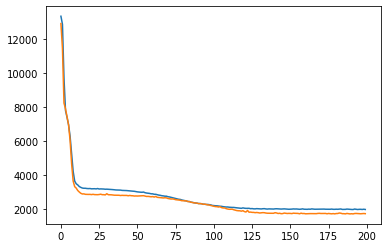

In [51]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])


In [31]:
model=tf.keras.models.load_model("insurance_model")

In [36]:
preds=model.predict(X_test_normal)


9/9 [==============================] - 0s 4ms/step


In [41]:
X_test.head(1),preds[0]

(     age     sex     bmi  children smoker     region
 764   45  female  25.175         2     no  northeast,
 array([9096.644], dtype=float32))

In [43]:
X_test.head(1),y_test.head(1)

(     age     sex     bmi  children smoker     region
 764   45  female  25.175         2     no  northeast, 764    9095.06825
 Name: charges, dtype: float64)